In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
import autokeras as ak
from hyperopt import hp
from hpsklearn import HyperoptEstimator , svc,random_forest

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [2]:
# current version of the hyperopt package is unstable, this notebook uses a previous version
%pip install hyperopt==0.2.5

In [3]:
df_tea = pd.read_csv(os.path.join('data-scientist-technical-test','data','auto-insurance-fall-2017','test_auto.csv'))

In [4]:
df_tra = pd.read_csv(os.path.join('data-scientist-technical-test','data','auto-insurance-fall-2017','train_auto.csv'))

In [5]:
df_tra.describe()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,5151.867663,0.263816,1504.324648,0.171057,44.790313,0.721235,10.499286,33.485725,5.351305,0.798554,1.695503,8.328323
std,2978.893962,0.440728,4704.026930,0.511534,8.627589,1.116323,4.092474,15.908333,4.146635,1.158453,2.147112,5.700742
min,1.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,-3.000000
25%,2559.000000,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,5133.000000,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,7745.000000,1.000000,1036.000000,0.000000,51.000000,1.000000,13.000000,44.000000,7.000000,2.000000,3.000000,12.000000
max,10302.000000,1.000000,107586.136160,4.000000,81.000000,5.000000,23.000000,142.000000,25.000000,5.000000,13.000000,28.000000


In [6]:
df_tea

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,3,NaN,NaN,0,48.0,0,11.0,"$52,881",No,$0,...,"$21,970",1,Van,yes,$0,0,No,2,10.0,Highly Urban/ Urban
1,9,NaN,NaN,1,40.0,1,11.0,"$50,815",Yes,$0,...,"$18,930",6,Minivan,no,"$3,295",1,No,2,1.0,Highly Urban/ Urban
2,10,NaN,NaN,0,44.0,2,12.0,"$43,486",Yes,$0,...,"$5,900",10,z_SUV,no,$0,0,No,0,10.0,z_Highly Rural/ Rural
3,18,NaN,NaN,0,35.0,2,NaN,"$21,204",Yes,$0,...,"$9,230",6,Pickup,no,$0,0,Yes,0,4.0,z_Highly Rural/ Rural
4,21,NaN,NaN,0,59.0,0,12.0,"$87,460",No,$0,...,"$15,420",1,Minivan,yes,"$44,857",2,No,4,1.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,10279,NaN,NaN,0,46.0,0,0.0,$0,No,$0,...,"$1,500",6,Sports Car,no,"$20,519",1,Yes,3,8.0,z_Highly Rural/ Rural
2137,10281,NaN,NaN,0,46.0,0,12.0,"$43,501",No,"$134,977",...,"$16,080",3,Minivan,no,$0,0,No,2,1.0,z_Highly Rural/ Rural
2138,10285,NaN,NaN,0,55.0,0,10.0,"$141,083",No,"$393,624",...,"$21,110",10,Sports Car,no,$0,0,No,0,22.0,z_Highly Rural/ Rural
2139,10294,NaN,NaN,0,51.0,0,10.0,"$128,523",No,$0,...,"$32,960",6,Panel Truck,no,"$3,995",3,No,1,15.0,Highly Urban/ Urban


### Check
Checking whether the target is balanced

In [7]:
df_tra.isna().sum()/df_tra.shape[0]*100

INDEX          0.000000
TARGET_FLAG    0.000000
TARGET_AMT     0.000000
KIDSDRIV       0.000000
AGE            0.073520
HOMEKIDS       0.000000
YOJ            5.563044
INCOME         5.452763
PARENT1        0.000000
HOME_VAL       5.685578
MSTATUS        0.000000
SEX            0.000000
EDUCATION      0.000000
JOB            6.445289
TRAVTIME       0.000000
CAR_USE        0.000000
BLUEBOOK       0.000000
TIF            0.000000
CAR_TYPE       0.000000
RED_CAR        0.000000
OLDCLAIM       0.000000
CLM_FREQ       0.000000
REVOKED        0.000000
MVR_PTS        0.000000
CAR_AGE        6.249234
URBANICITY     0.000000
dtype: float64

Since all columns have >90% of records valid we don't have to drop any of them (at least not because of too many None values)

### Check
Checking if there are any records which have many Null values. If there are, then we can drop them

<AxesSubplot:>

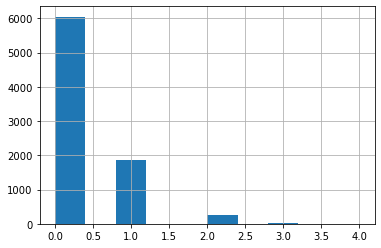

In [8]:
df_tra.isna().sum(axis = 1).hist()

Since no record has more than 4 Null values (out of 20 or so columns), we don't need to drop any of them.

### Check

Verifying whether there are any other currencies involved apart from dollars

In [9]:
x = pd.Series([i[0] for i in df_tra['INCOME'].fillna(';None;').to_numpy() ])
print ('INCOME', x.unique())

x = pd.Series([i[0] for i in df_tra['HOME_VAL'].fillna(';None;').to_numpy() ])
print ('HOME_VAL', x.unique())

x = pd.Series([i[0] for i in df_tra['BLUEBOOK'].fillna(';None;').to_numpy() ])
print ('BLUEBOOK', x.unique())

x = pd.Series([i[0] for i in df_tra['OLDCLAIM'].fillna(';None;').to_numpy() ])
print ('OLDCLAIM', x.unique())


INCOME ['$' ';']
HOME_VAL ['$' ';']
BLUEBOOK ['$']
OLDCLAIM ['$']


All currencies are in dollars so if we would preprocess currencies we don't need to preprocess them separately

## Analyzing histograms of features and of features belonging to targets 0/1

In [10]:
numeric_cols = ['KIDSDRIV','AGE','HOMEKIDS','YOJ','INCOME','HOME_VAL','TRAVTIME','BLUEBOOK','TIF','OLDCLAIM','CLM_FREQ','MVR_PTS','CAR_AGE']
curr_cols = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']
categ_cols = ['CAR_USE','CAR_TYPE','RED_CAR','REVOKED','URBANICITY','PARENT1','MSTATUS','SEX','EDUCATION','JOB']


In [11]:
pd.set_option('display.max_columns', None)

Looking at numerical columns first:

----------------- KIDSDRIV -----------------


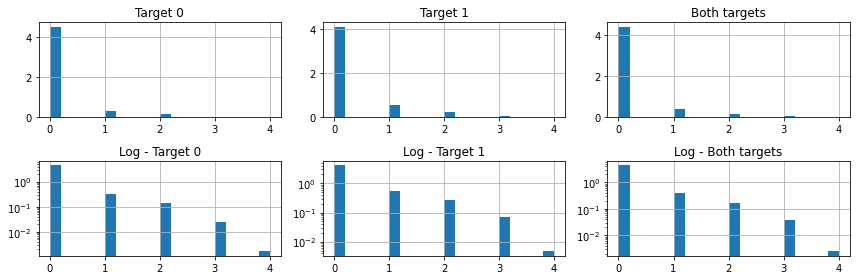

----------------- AGE -----------------


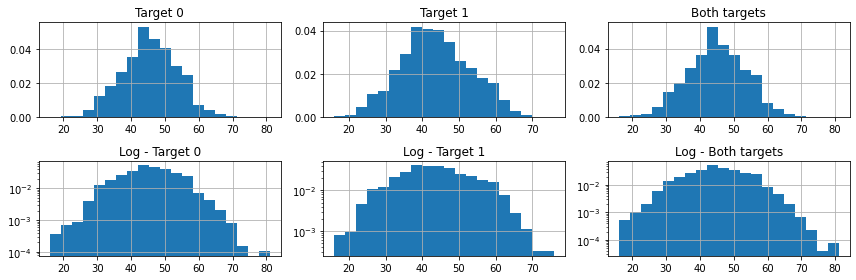

----------------- HOMEKIDS -----------------


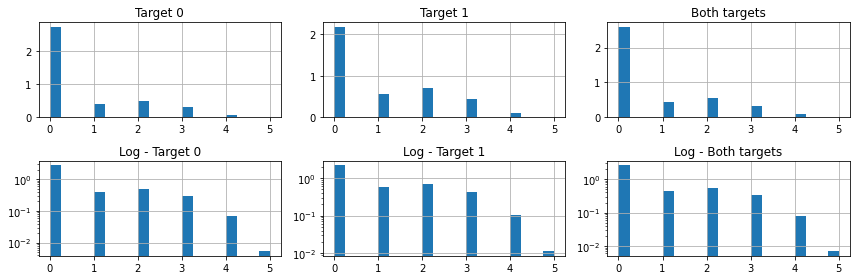

----------------- YOJ -----------------


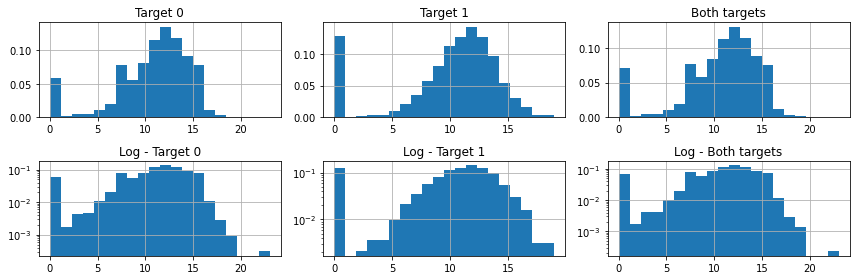

----------------- INCOME -----------------


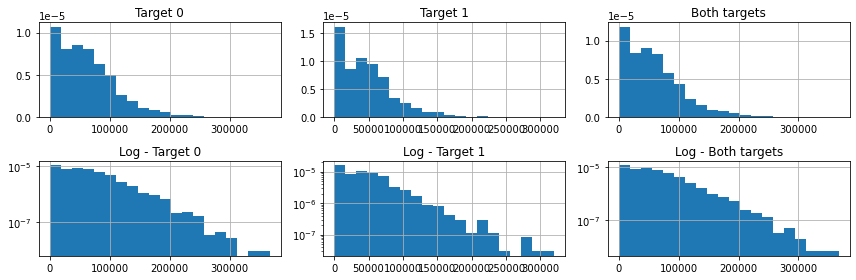

----------------- HOME_VAL -----------------


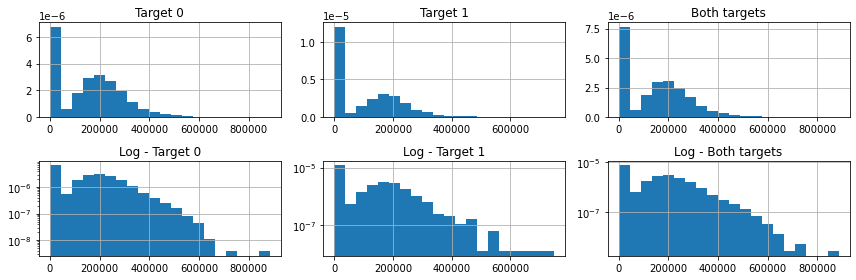

----------------- TRAVTIME -----------------


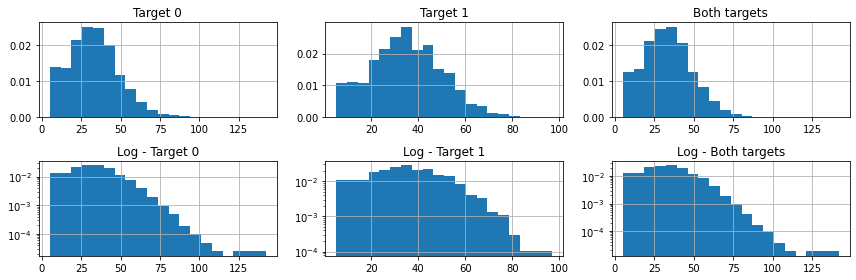

----------------- BLUEBOOK -----------------


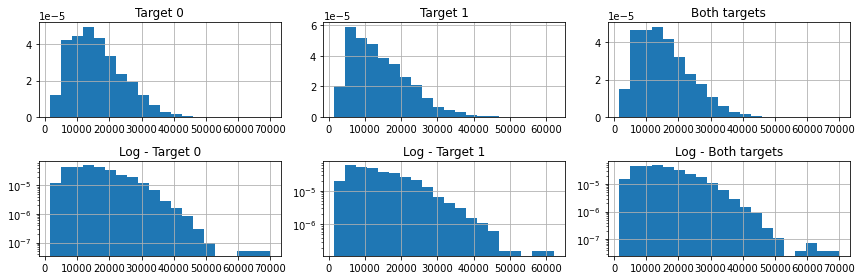

----------------- TIF -----------------


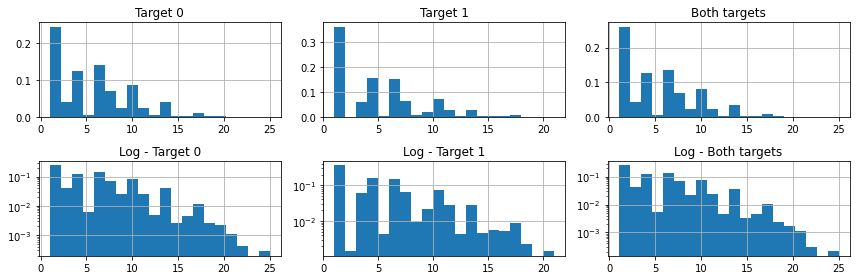

----------------- OLDCLAIM -----------------


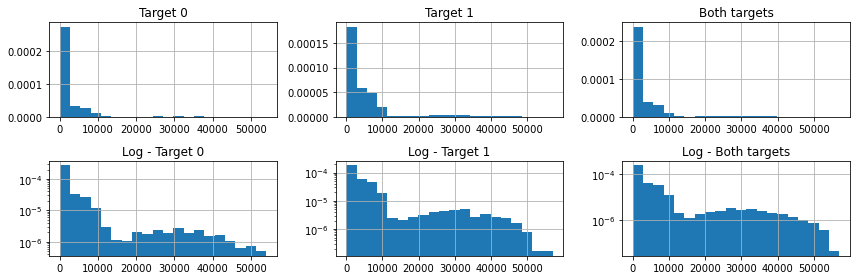

----------------- CLM_FREQ -----------------


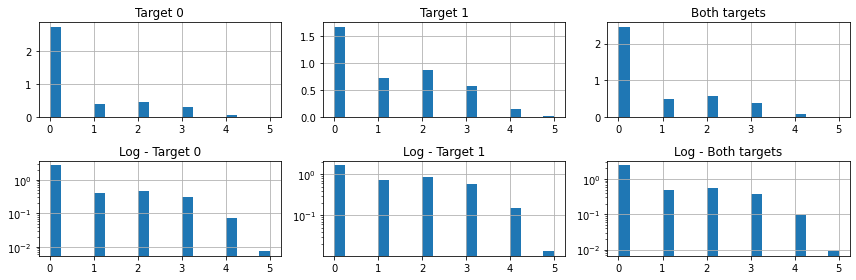

----------------- MVR_PTS -----------------


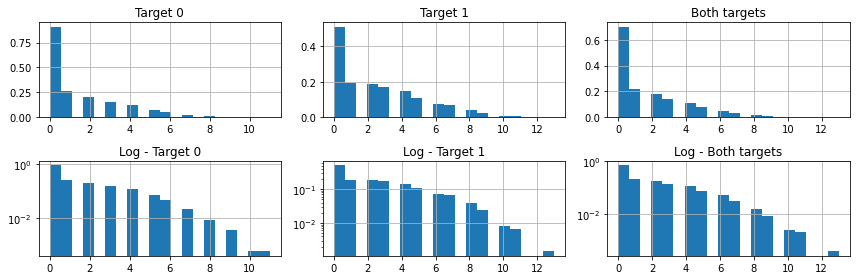

----------------- CAR_AGE -----------------


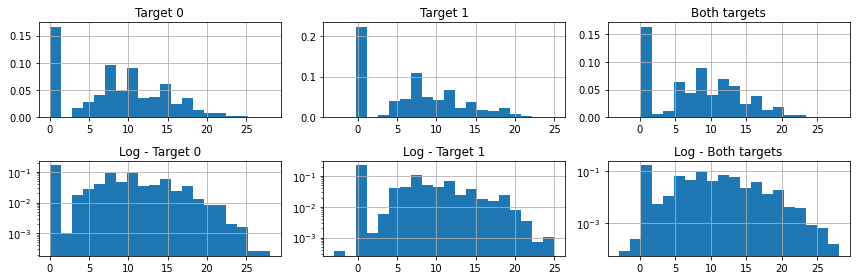

In [12]:
for col in numeric_cols:
    if col in curr_cols:
        # Transform currency columns into numerical columns
        ts = df_tra[df_tra['TARGET_FLAG']==1][col].fillna('$-1')
        fs = df_tra[df_tra['TARGET_FLAG']==0][col].fillna('$-1')
        ts = ts.apply(lambda x : float(re.sub('[\$,]', '', x)))
        fs = fs.apply(lambda x : float(re.sub('[\$,]', '', x)))
        d = df_tra[col].fillna('$-1')
        d = d.apply(lambda x : float(re.sub('[\$,]', '', x)))
        df_tra[col] = df_tra[col].fillna('$-1')
        df_tra[col] = df_tra[col].apply(lambda x : float(re.sub('[\$,]', '', x))).astype(float)
    else:
        # Use column as it is
        ts = df_tra[df_tra['TARGET_FLAG']==1][col]
        fs = df_tra[df_tra['TARGET_FLAG']==0][col]
        d = df_tra[col]
    
    # Plot the three historams
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (12,4))
    print ('-----------------',col, '-----------------')
    axes[0,0].set_title ('Target 0')
    axes[0,1].set_title ('Target 1')
    axes[0,2].set_title ('Both targets')
    fs.hist(ax=axes[0,0], density = True, bins = 20)
    ts.hist(ax=axes[0,1], density = True, bins = 20)
    d.hist(ax = axes[0,2], density = True, bins = 20)
    
    
    axes[1,0].set_title ('Log - Target 0')
    axes[1,1].set_title ('Log - Target 1')
    axes[1,2].set_title ('Log - Both targets')
    fs.hist(ax=axes[1,0], density = True, bins = 20, log = True)
    ts.hist(ax=axes[1,1], density = True, bins = 20, log = True)
    d.hist(ax =axes[1,2], density = True, bins = 20, log = True)
    fig.tight_layout()
    
    plt.show()

Looking at categorical columns:

----------------- CAR_USE -----------------


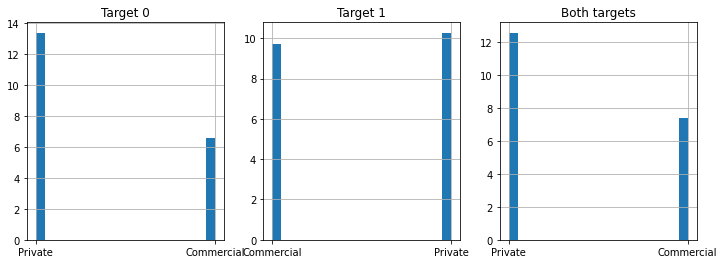

----------------- CAR_TYPE -----------------


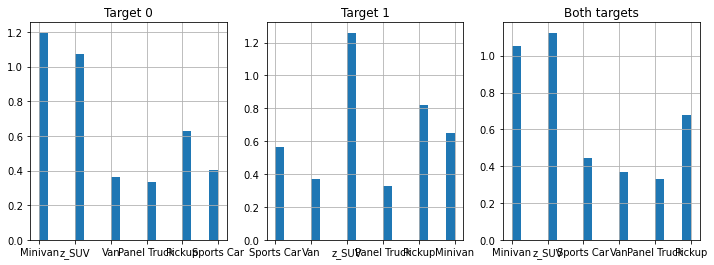

----------------- RED_CAR -----------------


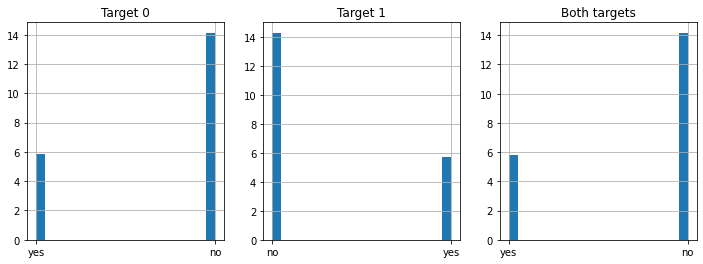

----------------- REVOKED -----------------


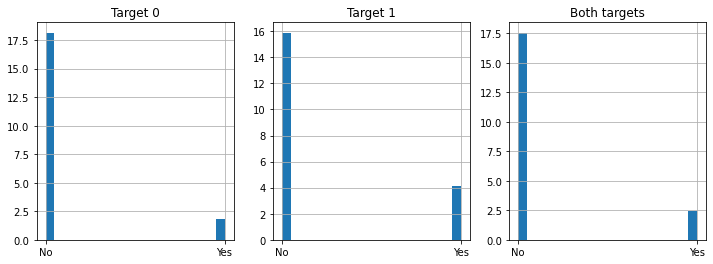

----------------- URBANICITY -----------------


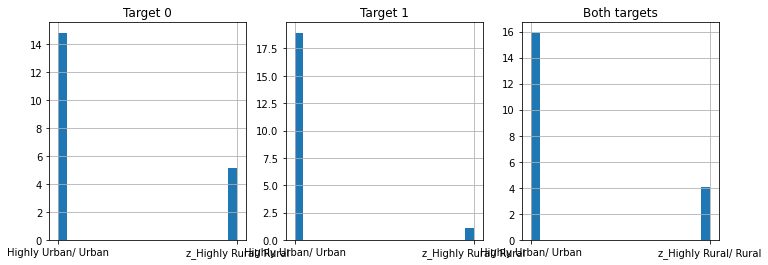

----------------- PARENT1 -----------------


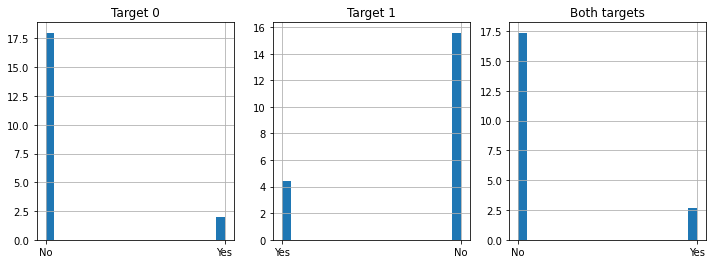

----------------- MSTATUS -----------------


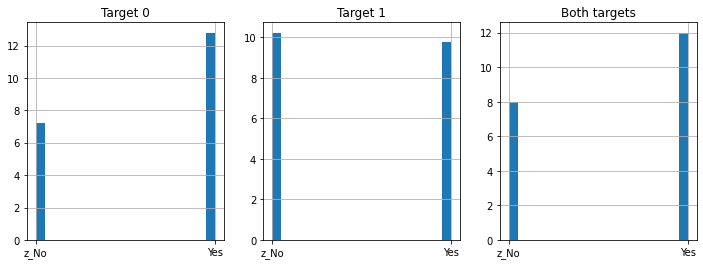

----------------- SEX -----------------


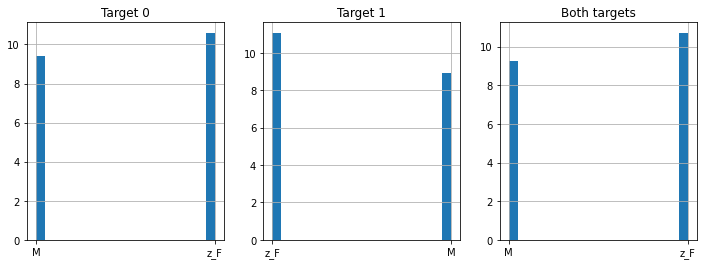

----------------- EDUCATION -----------------


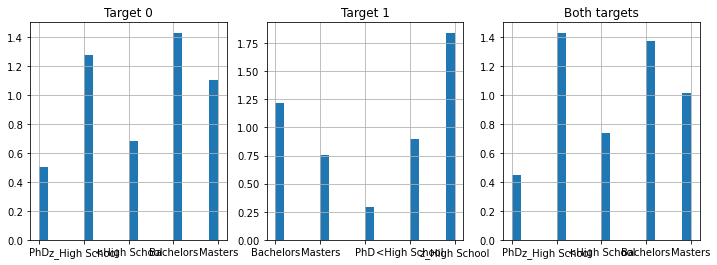

----------------- JOB -----------------


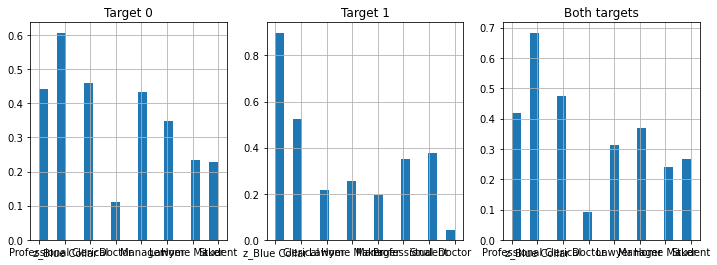

In [13]:

for col in categ_cols:
    ts = df_tra[df_tra['TARGET_FLAG']==1][col]
    fs = df_tra[df_tra['TARGET_FLAG']==0][col]
    df_tra[col] = df_tra[col].astype('category')
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (12,4))
    print ('-----------------',col, '-----------------')
    axes[0].set_title ('Target 0')
    axes[1].set_title ('Target 1')
    axes[2].set_title ('Both targets')
    fs.hist(ax=axes[0], density = True, bins = 20)
    ts.hist(ax=axes[1], density = True, bins = 20)
    df_tra[col].hist(ax = axes[2], density = True, bins = 20)
    plt.show()

## Cleaning, scaling and standardizing data

### Filling NULL values

In [14]:
# For categorical columns, just fill with the most common value
df_tra[categ_cols] = df_tra[categ_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))
# Without time constraints I would've also tried filling with the "Unkonwn" category

# For numerical columns, just fill with median value
# df['X2'] = df['X2'].fillna(df['X2'].median())
for nc in numeric_cols:
    med_val = df_tra[df_tra[nc]!=-1][nc].median()
    if nc in curr_cols:
        # fillna occured with value -1, we just have to replace it (since -1 didn't occur in any column previously) with med_val
        df_tra.loc[df_tra[nc]==-1, nc] = med_val
    else:
        # just fill NULL values with med_val
        df_tra[nc].fillna(med_val, inplace = True)

# Check that there are no NULL values anymore        
assert df_tra.isna().sum().sum() == 0

### Scaling and standardizing numeric data

In [15]:
scaler = preprocessing.MinMaxScaler()
df_tra[numeric_cols] = scaler.fit_transform(df_tra[numeric_cols])

scaler = preprocessing.StandardScaler()
df_tra[numeric_cols] = scaler.fit_transform(df_tra[numeric_cols])

# Splitting data

Sampling 4000 data (targets with value = True are about 2000 so 4000 samples should obtain a relatively balanced data set)

In [16]:

w = df_tra['TARGET_FLAG']
vc = w.value_counts()
w = 1 + (vc[0]/vc[1]-1)*w
s = df_tra['TARGET_FLAG'].sample(4000, weights = w, random_state = 888).index
df = df_tra.loc[s]
df_val = df_tra.loc[~df_tra.index.isin(s)]


In [17]:
print ('Training dataset is now of size:', df['TARGET_FLAG'].shape[0], 'and there are',df['TARGET_FLAG'].sum(), 'True values')

Training dataset is now of size: 4000 and there are 1629 True values


In [18]:
print ('The rest of the true values we can keep in a test set')
print ('Total nbr of records in test set:',df_val.shape[0], 'and total number of True values:',df_val['TARGET_FLAG'].sum())
print ("It is not balanced but this one doesn't need to be")

The rest of the true values we can keep in a test set
Total nbr of records in test set: 4161 and total number of True values: 524
It is not balanced but this one doesn't need to be


In [19]:

def split_data(df, tp = 'trtest'):
    lbl = preprocessing.OneHotEncoder()
    lbl.fit(df[categ_cols].astype(str))
    enc_feats = lbl.transform(df[categ_cols])
    feature_names = numeric_cols+list(lbl.get_feature_names_out())
    feats = np.concatenate((df[numeric_cols].to_numpy(),enc_feats.toarray()), axis=1)
    X, y = feats, df['TARGET_FLAG'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=789)
    
    if (tp == 'trtest'):
        return X_train, X_test, y_train, y_test, feature_names
    elif(tp == 'alldataset'):
        return X, y, feature_names
    
    
X_train, X_val, y_train, y_val, feature_names = split_data(df)
X_test,y_test, _ = split_data(df_val, 'alldataset')
X,y, _  = split_data(df_tra, 'alldataset')

In [20]:
y_train.shape[0], y_train.sum(), y_test.shape[0], y_test.sum(), y_val.shape[0], y_val.sum()

(3200, 1303, 4161, 524, 800, 326)

# XGBoost

In [23]:
def train_and_test_XGB(X_train, y_train, X_test,lr,max_depth,alpha,n_est):
    
    xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = lr,
                    max_depth = max_depth, alpha = alpha, n_estimators = n_est)
    xg_reg.fit(X_train,y_train)
    preds = xg_reg.predict(X_test)
    
    return preds


f1max = 0
n_est = 100
for lr in np.arange(0.1,1,0.1):
    print (lr)
    for max_depth in range (3,20):
#         print (max_depth)
        for alpha in range (0,3):
            preds = train_and_test_XGB(X_train, y_train, X_val,lr,max_depth,alpha,n_est)
            f1 = f1_score(y_val, preds)
            if f1>f1max:
                lrmax = lr
                mdmax = max_depth
                amax = alpha
                f1max = f1
        

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9


In [26]:
print ('Best f1 attempted:', f1max)

Best f1 attempted: 0.6677524429967427


Testing best model on remaining validation data:

In [27]:

preds = train_and_test_XGB(X_train,y_train,X_test,lrmax,mdmax,amax,n_est)
print ('Validation f1:', round(f1_score(y_test, preds),3), 
            'precision:', round(precision_score(y_test,preds),3), 
            'recall', round(recall_score(y_test,preds),3))
print ('confusion matrix:')
print (confusion_matrix(y_test, preds))

Validation f1: 0.436 precision: 0.33 recall 0.643
confusion matrix:
[[2952  685]
 [ 187  337]]


Testing XGBoost with best parameters from before (not necessarily optimal ones) on entire dataset to check performance overall. I didn't have the time to implement a balancing of the dataset inside the kfold, nevertheless it gives a general idea of the expected performance overall.

In [28]:
kf = StratifiedKFold(n_splits=5)
kf.get_n_splits(X)
for train_index, val_index in kf.split(X, y):
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X[train_index],X[val_index],y[train_index],y[val_index]
    preds = train_and_test_XGB(X_train_kf,y_train_kf,X_val_kf,lrmax,mdmax,amax,n_est)
    
    print ('f1:', round(f1_score(y_val_kf, preds),3), 
            'precision:', round(precision_score(y_val_kf,preds),3), 
            'recall:', round(recall_score(y_val_kf,preds),3))
    print ('confusion matrix:')
    print (confusion_matrix(y_val_kf, preds))

f1: 0.546 precision: 0.654 recall: 0.469
confusion matrix:
[[1095  107]
 [ 229  202]]
f1: 0.561 precision: 0.66 recall: 0.488
confusion matrix:
[[1094  108]
 [ 220  210]]
f1: 0.534 precision: 0.693 recall: 0.435
confusion matrix:
[[1119   83]
 [ 243  187]]
f1: 0.504 precision: 0.712 recall: 0.39
confusion matrix:
[[1133   68]
 [ 263  168]]
f1: 0.515 precision: 0.65 recall: 0.427
confusion matrix:
[[1102   99]
 [ 247  184]]


We can see that on the general unbalanced dataset we can expect an f1 score around 0.53.

XGBoost feature importance:

In [29]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = lrmax,
                    max_depth = max_depth, alpha = alpha, n_estimators = n_est)
xg_reg.fit(X_train,y_train)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=19, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=2, ...)

[0.02034499 0.009654   0.01091774 0.00653913 0.00999097 0.00987569
 0.00883784 0.00912811 0.00840886 0.01768626 0.02684927 0.0121119
 0.00963449 0.01745506 0.01920708 0.03779272 0.00567715 0.00486667
 0.00844226 0.0091785  0.01053328 0.00555206 0.00634886 0.03160905
 0.01662312 0.17755888 0.26061004 0.01339143 0.0369816  0.01124975
 0.01332897 0.00755918 0.00768116 0.0105789  0.00959026 0.01063654
 0.00692546 0.02160098 0.00573938 0.00760644 0.00613334 0.00694924
 0.03006643 0.00620177 0.00704987 0.00929526]


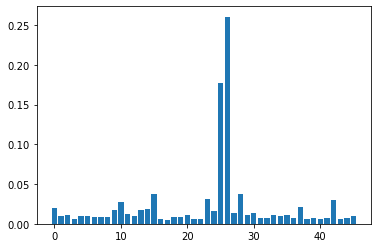

In [30]:
print(xg_reg.feature_importances_)
# plot
plt.bar(range(len(xg_reg.feature_importances_)), xg_reg.feature_importances_)
plt.show()

In [31]:
fi = {feature_names[i]:xg_reg.feature_importances_[i] for i in range (len(feature_names))}

In [32]:
{k: v for k, v in sorted(fi.items(), key=lambda item: item[1])}

{'CAR_TYPE_Pickup': 0.00486667,
 'RED_CAR_no': 0.0055520646,
 'CAR_TYPE_Panel Truck': 0.0056771473,
 'JOB_Clerical': 0.005739385,
 'JOB_Home Maker': 0.0061333384,
 'JOB_Professional': 0.00620177,
 'RED_CAR_yes': 0.006348858,
 'YOJ': 0.00653913,
 'EDUCATION_PhD': 0.0069254627,
 'JOB_Lawyer': 0.0069492403,
 'JOB_Student': 0.007049874,
 'SEX_M': 0.007559179,
 'JOB_Doctor': 0.0076064435,
 'SEX_z_F': 0.0076811584,
 'TIF': 0.008408859,
 'CAR_TYPE_Sports Car': 0.008442264,
 'TRAVTIME': 0.008837844,
 'BLUEBOOK': 0.009128106,
 'CAR_TYPE_Van': 0.009178496,
 'JOB_z_Blue Collar': 0.009295262,
 'EDUCATION_Bachelors': 0.009590261,
 'CAR_AGE': 0.009634492,
 'AGE': 0.009654002,
 'HOME_VAL': 0.009875694,
 'INCOME': 0.009990973,
 'CAR_TYPE_z_SUV': 0.01053328,
 'EDUCATION_<High School': 0.0105789015,
 'EDUCATION_Masters': 0.010636543,
 'HOMEKIDS': 0.010917741,
 'MSTATUS_Yes': 0.011249745,
 'MVR_PTS': 0.012111902,
 'MSTATUS_z_No': 0.013328973,
 'PARENT1_No': 0.013391428,
 'REVOKED_Yes': 0.016623123,
 'CAR

It seems XGBoost has found that the most important feature to take into account is whether the car in question is in a rural place or not. I expected this feature to be important after I looked at the histograms plotted above showcasing the categorical variables distribution for different targets. Rural cars are much less likely to be involved in accidents than urban ones. This outcome is expected and shows that the model has most likely been trained correctly.

# Random Forest - HPSKLearn

For Random Forest I will use the HyperoptEstimator from Hpsklearn. This package was specifically made to search for hyperparameters mathematically, optimising them in a smart and fast manner. It has performed well from my experience so far, so I'll be using it here

https://hyperopt.github.io/hyperopt-sklearn/#what-is-hyperopt-sklearn

In [33]:
clf = hp.pchoice( 'my_name', 
          [ ( 1.0, random_forest('my_name.random_forest') )])

estim = HyperoptEstimator( classifier=clf,max_evals=10, trial_timeout=60 )
estim.fit( X_train, y_train )

100%|███████████████████████████████████████████████| 10/10 [00:04<00:00,  4.98s/trial, best loss: 0.27656250000000004]


In [34]:
# Make a prediction using the optimized model
preds = estim.predict( X_val )
# HyperoptEstimator( classifier=any_classifier('clf'),

print ('f1:', round(f1_score(y_val, preds),3), 
            'precision:', round(precision_score(y_val,preds),3), 
            'recall:', round(recall_score(y_val,preds),3))
print ('confusion matrix:')
print (confusion_matrix(y_val, preds))

f1: 0.657 precision: 0.688 recall: 0.629
confusion matrix:
[[381  93]
 [121 205]]


In [35]:
# Make a prediction using the optimized model
preds = estim.predict( X_test )
# HyperoptEstimator( classifier=any_classifier('clf'),

print ('f1:', round(f1_score(y_test, preds),3), 
            'precision:', round(precision_score(y_test,preds),3), 
            'recall:', round(recall_score(y_test,preds),3))
print ('confusion matrix:')
print (confusion_matrix(y_test, preds))

f1: 0.432 precision: 0.333 recall: 0.616
confusion matrix:
[[2989  648]
 [ 201  323]]


Random Forest seems to perform similarly to XGBoost. With results so close, using either seems to bring about the same value.

# SVC - HPSKLearn

In [36]:
clf = hp.pchoice( 'my_name', 
          [ ( 1.0, svc('my_name.svc') )])

estim = HyperoptEstimator( classifier=clf,max_evals=10, trial_timeout=60 )
estim.fit( X_train, y_train )

100%|███████████████████████████████████████████████| 10/10 [00:01<00:00,  1.68s/trial, best loss: 0.30000000000000004]


In [37]:
# Make a prediction using the optimized model
preds = estim.predict( X_val )
# HyperoptEstimator( classifier=any_classifier('clf'),

print ('f1:', round(f1_score(y_val, preds),3), 
            'precision:', round(precision_score(y_val,preds),3), 
            'recall:', round(recall_score(y_val,preds),3))
print ('confusion matrix:')
print (confusion_matrix(y_val, preds))

f1: 0.659 precision: 0.689 recall: 0.632
confusion matrix:
[[381  93]
 [120 206]]


In [38]:
# Make a prediction using the optimized model
preds = estim.predict( X_test )
# HyperoptEstimator( classifier=any_classifier('clf'),

print ('f1:', round(f1_score(y_test, preds),3), 
            'precision:', round(precision_score(y_test,preds),3), 
            'recall:', round(recall_score(y_test,preds),3))
print ('confusion matrix:')
print (confusion_matrix(y_test, preds))

f1: 0.423 precision: 0.314 recall: 0.649
confusion matrix:
[[2895  742]
 [ 184  340]]


SVC doesn't seem to do a very good job on this dataset. This is probably because the SVC has a linear kernel and can't find nonlinear relationships

# Fully Connected Neural Network - Autokeras

Similar to HPSKLearn, Autokeras' purpose is to rapidly optimize the structure of neural networks.

In [39]:
cls = ak.StructuredDataClassifier(overwrite = True, max_trials = 10)
cls.fit(X_train,y_train, epochs = 100)

Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.7015625238418579

Best val_accuracy So Far: 0.7171875238418579
Total elapsed time: 00h 02m 02s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
100/100 [==============================] - 1s 1ms/step - loss: 0.7842 - accuracy: 0.5516
Epoch 2/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6799 - accuracy: 0.5944
Epoch 3/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6589 - accuracy: 0.6247
Epoch 4/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6499 - accuracy: 0.6228
Epoch 5/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6357 - accuracy: 0.6438
Epoch 6/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6149 - accuracy: 0.6666
Epoch 7/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6180 - accuracy: 0.6691
Epoch 8/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6108 - accuracy: 0.6653
Epoch 9/100

100/100 [==============================] - 0s 1ms/step - loss: 0.4576 - accuracy: 0.7837
Epoch 80/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4561 - accuracy: 0.7891
Epoch 81/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4595 - accuracy: 0.7856
Epoch 82/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4558 - accuracy: 0.7847
Epoch 83/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.7894
Epoch 84/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4530 - accuracy: 0.7919
Epoch 85/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4518 - accuracy: 0.7866
Epoch 86/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4506 - accuracy: 0.7928
Epoch 87/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4493 - accuracy: 0.7925
Epoch 88/100
100/100 [==============================] - 0s 1ms/step - loss: 0.4390 - accuracy: 

In [40]:
preds = cls.predict(X_val)
print ('f1:', round(f1_score(y_val, preds),3), 
            'precision:', round(precision_score(y_val,preds),3), 
            'recall:', round(recall_score(y_val,preds),3))
print ('confusion matrix:')
print (confusion_matrix(y_val, preds))

25/25 [==============================] - 0s 1ms/step
f1: 0.61 precision: 0.672 recall: 0.558
confusion matrix:
[[385  89]
 [144 182]]


In [41]:
preds = cls.predict(X_test)
print ('f1:', round(f1_score(y_test, preds),3), 
            'precision:', round(precision_score(y_test,preds),3), 
            'recall:', round(recall_score(y_test,preds),3))
print ('confusion matrix:')
print (confusion_matrix(y_test, preds))

131/131 [==============================] - 0s 1ms/step
f1: 0.404 precision: 0.319 recall: 0.552
confusion matrix:
[[3020  617]
 [ 235  289]]


Neural networks seem to perform (very) slightly worse than XGBoost. Given the present circumstances, I'd use XGBoost because it's also faster to train

# Conclusion

XGBoost seems to be the model of choice for our purpose here because of its high f1_score (relative to the others) on both test and validation datasets. I will thus use this model to predict the unknown data.

So I'll perform all preprocessing steps on the unknown dataset first, and then predict on it. I would expect an f1 of about 0.50-0.55

In [42]:
for col in numeric_cols:
    if col in curr_cols:
        # Transform currency columns into numerical columns
        ts = df_tea[df_tea['TARGET_FLAG']==1][col].fillna('$-1')
        fs = df_tea[df_tea['TARGET_FLAG']==0][col].fillna('$-1')
        ts = ts.apply(lambda x : float(re.sub('[\$,]', '', x)))
        fs = fs.apply(lambda x : float(re.sub('[\$,]', '', x)))
        d = df_tea[col].fillna('$-1')
        d = d.apply(lambda x : float(re.sub('[\$,]', '', x)))
        df_tea[col] = df_tea[col].fillna('$-1')
        df_tea[col] = df_tea[col].apply(lambda x : float(re.sub('[\$,]', '', x))).astype(float)




df_tea[categ_cols] = df_tea[categ_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))
for nc in numeric_cols:
    med_val = df_tea[df_tea[nc]!=-1][nc].median()
    if nc in curr_cols:
        df_tea.loc[df_tea[nc]==-1, nc] = med_val
    else:
        df_tea[nc].fillna(med_val, inplace = True)
        
 
        

scaler = preprocessing.MinMaxScaler()
df_tea[numeric_cols] = scaler.fit_transform(df_tea[numeric_cols])

scaler = preprocessing.StandardScaler()
df_tea[numeric_cols] = scaler.fit_transform(df_tea[numeric_cols])


        
lbl = preprocessing.OneHotEncoder()
lbl.fit(df_tea[categ_cols].astype(str))
enc_feats = lbl.transform(df_tea[categ_cols])
feature_names = numeric_cols+list(lbl.get_feature_names_out())
feats = np.concatenate((df_tea[numeric_cols].to_numpy(),enc_feats.toarray()), axis=1)
X = feats

In [43]:
# Retraining model as it was never returned from the function which created it
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = lr,
                    max_depth = max_depth, alpha = alpha, n_estimators = n_est)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X)

And now we have the predictions for the unknown data:

In [44]:
preds

array([1, 0, 0, ..., 0, 0, 1])